<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Функция-подбора-окна-скользящего-среднего--и-количества-отстающих-признаков-и-функция-для-разбиения-и-масштабирования-признаков" data-toc-modified-id="Функция-подбора-окна-скользящего-среднего--и-количества-отстающих-признаков-и-функция-для-разбиения-и-масштабирования-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функция подбора окна скользящего среднего  и количества отстающих признаков и функция для разбиения и масштабирования признаков</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-комментарий" data-toc-modified-id="Общий-комментарий-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий комментарий</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Задача: Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.

## Подготовка

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer 

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    print('Файл успешно загружен!')
except:
    print('Ошибка загрузки файла ...')

Мы загрузили данные и даты убрали в индексы. Сделаем ресемплирование по одному часу.

In [3]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Проверим точно ли данные расположены в хронологическом порядке.

In [5]:
data.index.is_monotonic

True

Декомпозируем данные на тренд и сезонность. Сначала для всех данных.

In [6]:
decomposed = seasonal_decompose(data)

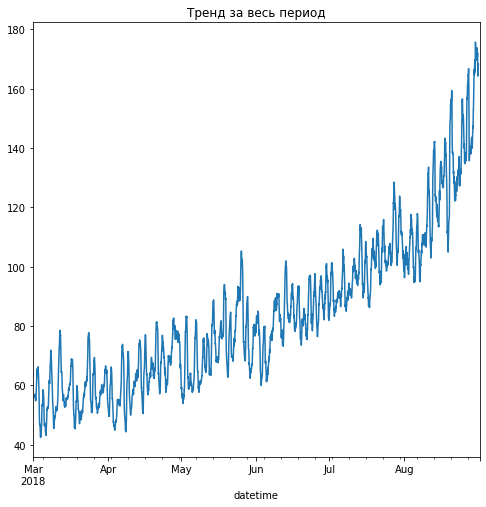

In [7]:
plt.figure(figsize=(8, 8))
decomposed.trend.plot(ax=plt.gca(), title = 'Тренд за весь период');

Наблюдается общий тренд к увеличению числа заказов такси за весь период наблюдений.

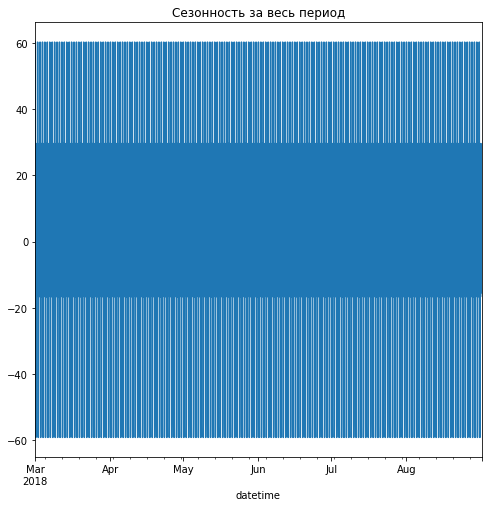

In [8]:
plt.figure(figsize=(8, 8))
decomposed.seasonal.plot(ax=plt.gca(), title= 'Сезонность за весь период');

О сезонности на всех данных сказать сложно, если она, например, есть по дням или часам, то нужно уменьшить масштаб рассматриваемых данных.

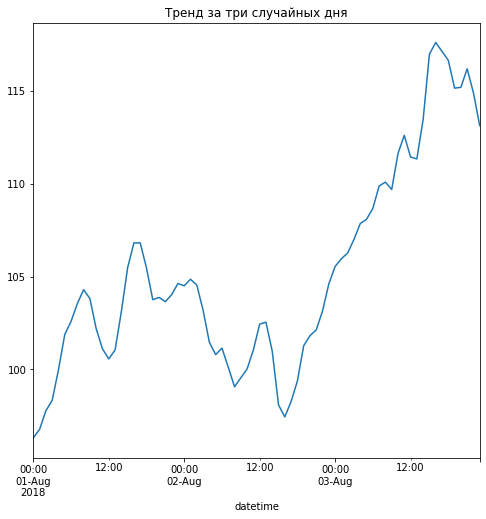

In [9]:
plt.figure(figsize=(8, 8))
decomposed.trend['2018-08-01':'2018-08-03'].plot(ax=plt.gca(), title= 'Тренд за три случайных дня');

О тренде на 3 днях судить сложно, но мы видели, что долгосрочный тренд есть точно.

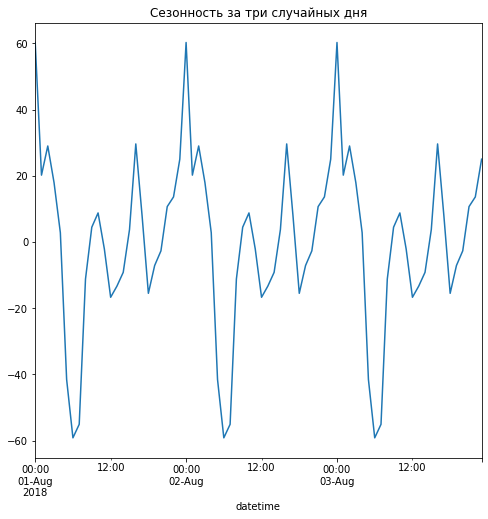

In [10]:
plt.figure(figsize=(8, 8))
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca(), title= 'Сезонность за три случайных дня');

Наблюдается сезонность по каждому дню. Есть пики в опредленное время суток, наиболее сильные скачки к концу дня.

Для обучения моделей и дальнейшего предсказания нам понадобятся новые признаки. Для выбора параметров на сколько смещать отстающие значения и какое окно выбирать для скользящего среднего создадим функцию, которая будет формировать новые признаки. А применять ее будем в цикле подбора параметров.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

## Обучение

### Функция подбора окна скользящего среднего  и количества отстающих признаков и функция для разбиения и масштабирования признаков

Создадим функцию для разбиения признаков и их масштабирования.Будет принимать датафрейм и переменную, показывающую нужно ли разбивать на на трейн, валид и тест или только на трейн и тест.

In [13]:
def split_scaler(data_for_model, three = 1):
    if three == 0:
        train, test = train_test_split(data_for_model, shuffle=False, test_size=0.1)
        train = train.dropna()
        target_train= train['num_orders']
        features_train  = train.drop('num_orders', axis = 1)
        target_test= test['num_orders']
        features_test = test.drop('num_orders', axis = 1)
        numeric = features_train.columns[3:]
        scaler = StandardScaler()
        scaler.fit(features_train[numeric])
        features_train[numeric] = scaler.transform(features_train[numeric])
        features_test[numeric] = scaler.transform(features_test[numeric])
        return features_train, target_train, features_test, target_test
    else:
        train, valid = train_test_split(data_for_model, shuffle=False, test_size=0.2)
        valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
        train = train.dropna()
        target_train= train['num_orders']
        features_train  = train.drop('num_orders', axis = 1)
        target_valid= valid['num_orders']
        features_valid = valid.drop('num_orders', axis = 1)
        target_test= test['num_orders']
        features_test = test.drop('num_orders', axis = 1)        
        numeric = features_train.columns[3:]
        scaler = StandardScaler()
        scaler.fit(features_train[numeric])
        features_train[numeric] = scaler.transform(features_train[numeric])
        features_valid[numeric] = scaler.transform(features_valid[numeric])
        features_test[numeric] = scaler.transform(features_test[numeric])
        return features_train, target_train,features_valid, target_valid, features_test, target_test

Реализуем функцию подбора окна скользящего среднего и количесвта отстающих признаков для разных моделей. Она будет принимать на вход модель, а на выходе выдавать при каких признаках получились наилучшие результаты.

In [14]:
def parameter_selection(model):
    min_error = 10000
    best_rolling_mean_size = 0
    best_lag = 0

    for i in range(24,96,24):
        for j in (1, 2, 24, 25, 48):
            data_for_model = data.copy()
            make_features(data_for_model, j, i)
            features_train, target_train,features_valid, target_valid,  features_test, target_test = split_scaler(data_for_model)
        

            model.fit(features_train, target_train)
            if mean_squared_error(model.predict(features_valid), target_valid,  squared = False)<min_error:
                min_error = mean_squared_error(model.predict(features_valid), target_valid,  squared = False)
                best_rolling_mean_size = i
                best_lag = j
                
    return best_lag, best_rolling_mean_size

### LightGBM

Подберем какие из признаков стоит добавить 

In [15]:
model_1 = LGBMRegressor(num_threads=8, max_depth=5)
parameter_selection(model_1)

Результат: 
- best_lag = 48
- best_rolling_mean_size = 72

 Создадим признаки и разделим данные на выборки с помощью функций, затем подберем параметры модели.

In [16]:
data_for_model_1 = data.copy()

In [17]:
make_features(data_for_model_1, 48, 72)

In [18]:
features_train1, target_train1, features_test1, target_test1 = split_scaler(data_for_model_1, three =0)

In [19]:
model_1 = LGBMRegressor(metric = 'rmse')

In [20]:
grid = {'max_depth': [4, 6, 10],
        'min_data_in_leaf':[20,30,40]}

tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(estimator=model_1, cv=tscv, param_grid=grid)
gs.fit(features_train1, target_train1)
gs.best_params_

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

{'max_depth': 4, 'min_data_in_leaf': 20}

Лучшие параметры: {'max_depth': 4, 'min_data_in_leaf': 20}

In [21]:
model_1 = LGBMRegressor(metric = 'rmse', max_depth =4, min_data_in_leaf = 20)

In [22]:
rmse_score = make_scorer(mean_squared_error, squared=False)
tcv = TimeSeriesSplit(n_splits=5)
rmse_gbm = cross_val_score(model_1,features_train1, target_train1, scoring=rmse_score, cv= tcv) 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [23]:
print('RMSE:', rmse_gbm)

RMSE: [21.44980513 21.34621599 23.18468015 23.5403292  31.49564601]


### RandomForestRegressor

In [24]:
model_2 = RandomForestRegressor()
parameter_selection(model_2)  

Результат: 
- best_lag = 48
- best_rolling_mean_size = 48

In [25]:
data_for_model_2 = data.copy()

In [26]:
make_features(data_for_model_2, 48, 48)

In [27]:
features_train2, target_train2, features_test2, target_test2 = split_scaler(data_for_model_2, three =0)

In [28]:
model_2 = RandomForestRegressor()

In [29]:
grid = {'max_depth': [4, 6, 10], 
        'n_estimators':[50,100,150,]}

tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(estimator=model_2, cv=tscv, param_grid=grid)
gs.fit(features_train2, target_train2)
gs.best_params_

{'max_depth': 10, 'n_estimators': 150}

Лучшие параметры: {'max_depth': 10, 'n_estimators': 150}

In [30]:
model_2 = RandomForestRegressor( max_depth = 10, n_estimators = 150)

In [31]:
rmse_score = make_scorer(mean_squared_error, squared=False)
tcv = TimeSeriesSplit(n_splits=5)
rmse_rf = cross_val_score(model_2,features_train2, target_train2, scoring=rmse_score, cv= tcv) 

In [32]:
print('RMSE:', rmse_rf)

RMSE: [21.87930395 22.11984497 23.33136283 23.97220311 32.51789932]


### CatBoost

In [33]:
model_3 = CatBoostRegressor(loss_function='RMSE', iterations=100)
parameter_selection(model_3) 

Результат: 
- best_lag = 48
- best_rolling_mean_size =72

In [63]:
data_for_model_3 = data.copy()
make_features(data_for_model_3, 48, 72)
features_train3, target_train3, features_test3, target_test3 = split_scaler(data_for_model_3, three =0)

In [35]:
model_3 = CatBoostRegressor(loss_function='RMSE', iterations=100)

In [36]:
grid = {'learning_rate': [0.03, 0.1], 
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(estimator=model_3, cv=tscv, param_grid=grid)
gs.fit(features_train3, target_train3)
gs.best_params_

0:	learn: 29.0703987	total: 49ms	remaining: 4.85s
1:	learn: 28.6828279	total: 51.3ms	remaining: 2.52s
2:	learn: 28.3162147	total: 53.4ms	remaining: 1.73s
3:	learn: 27.9400409	total: 55.5ms	remaining: 1.33s
4:	learn: 27.5930369	total: 57.5ms	remaining: 1.09s
5:	learn: 27.2706615	total: 59.5ms	remaining: 932ms
6:	learn: 26.9429899	total: 61.5ms	remaining: 817ms
7:	learn: 26.6429411	total: 63.4ms	remaining: 729ms
8:	learn: 26.4050493	total: 65.4ms	remaining: 662ms
9:	learn: 26.1032553	total: 67.5ms	remaining: 608ms
10:	learn: 25.8603078	total: 69.8ms	remaining: 565ms
11:	learn: 25.5571116	total: 71.8ms	remaining: 526ms
12:	learn: 25.2529111	total: 73.8ms	remaining: 494ms
13:	learn: 25.0085943	total: 75.9ms	remaining: 466ms
14:	learn: 24.7582525	total: 77.9ms	remaining: 441ms
15:	learn: 24.5068004	total: 80ms	remaining: 420ms
16:	learn: 24.2666911	total: 82ms	remaining: 400ms
17:	learn: 24.0117255	total: 84.1ms	remaining: 383ms
18:	learn: 23.7829581	total: 86.1ms	remaining: 367ms
19:	learn

KeyboardInterrupt: 

Лучшие параметры: {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [64]:
model_3 = CatBoostRegressor(loss_function='RMSE', iterations=100, depth= 6, l2_leaf_reg= 1, learning_rate= 0.1)

In [38]:
rmse_score = make_scorer(mean_squared_error, squared=False)
tcv = TimeSeriesSplit(n_splits=5)
rmse_c = cross_val_score(model_3,features_train3, target_train3, scoring=rmse_score, cv= tcv) 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 28.0729856	total: 6.37ms	remaining: 630ms
1:	learn: 26.8099369	total: 12ms	remaining: 588ms
2:	learn: 25.6456983	total: 17.4ms	remaining: 564ms
3:	learn: 24.7154878	total: 23.5ms	remaining: 564ms
4:	learn: 23.8199108	total: 31.5ms	remaining: 598ms
5:	learn: 23.0653441	total: 38.7ms	remaining: 606ms
6:	learn: 22.3501770	total: 43.8ms	remaining: 582ms
7:	learn: 21.7167565	total: 48.9ms	remaining: 562ms
8:	learn: 21.1925521	total: 53.9ms	remaining: 545ms
9:	learn: 20.6196969	total: 58.9ms	remaining: 530ms
10:	learn: 20.2025619	total: 64.3ms	remaining: 521ms
11:	learn: 19.7683149	total: 69.4ms	remaining: 509ms
12:	learn: 19.3449524	total: 74.4ms	remaining: 498ms
13:	learn: 18.9860191	total: 79.4ms	remaining: 487ms
14:	learn: 18.6526802	total: 84.4ms	remaining: 479ms
15:	learn: 18.2932131	total: 89.6ms	remaining: 470ms
16:	learn: 17.9502735	total: 94.8ms	remaining: 463ms
17:	learn: 17.6679539	total: 99.9ms	remaining: 455ms
18:	learn: 17.4433797	total: 105ms	remaining: 447ms
19:	le

In [39]:
print('RMSE:', rmse_c)

RMSE: [21.17606707 21.39234971 22.79398737 23.6371957  31.95394902]


### Выбор модели

Выведем среднюю rmse лучших моделей.

In [109]:
pd.DataFrame({'LightGMB': sum(rmse_gbm)/len(rmse_gbm), 
              'RandomForest' :  sum(rmse_rf)/len(rmse_rf),
               'Catboost': sum(rmse_c)/len(rmse_c)}, index = ['rmse_mean']) 

,LightGMB,RandomForest,Catboost
rmse_mean,24.203335,24.764123,24.19071


По результатам кросс-валидации средняя RMSE лучше всего у CatBoost. Ее и выберем для теста.

## Тестирование

Обучим нашу модель заново и проверим на тесте.

In [65]:
model_3.fit(features_train3, target_train3)
predict_c = model_3.predict(features_test3)

0:	learn: 36.8691271	total: 10.2ms	remaining: 1s
1:	learn: 35.1768430	total: 19.4ms	remaining: 953ms
2:	learn: 33.7438443	total: 28.9ms	remaining: 933ms
3:	learn: 32.4366449	total: 38.3ms	remaining: 919ms
4:	learn: 31.2944070	total: 47.3ms	remaining: 900ms
5:	learn: 30.2229454	total: 61.2ms	remaining: 958ms
6:	learn: 29.3579875	total: 71.7ms	remaining: 953ms
7:	learn: 28.5823565	total: 80.9ms	remaining: 931ms
8:	learn: 27.9192700	total: 90ms	remaining: 910ms
9:	learn: 27.3078705	total: 98.8ms	remaining: 890ms
10:	learn: 26.7742199	total: 108ms	remaining: 871ms
11:	learn: 26.3275679	total: 116ms	remaining: 854ms
12:	learn: 25.9259770	total: 125ms	remaining: 837ms
13:	learn: 25.5191261	total: 134ms	remaining: 823ms
14:	learn: 25.2120140	total: 143ms	remaining: 810ms
15:	learn: 24.9196520	total: 157ms	remaining: 823ms
16:	learn: 24.6503472	total: 166ms	remaining: 810ms
17:	learn: 24.4083965	total: 175ms	remaining: 799ms
18:	learn: 24.2328009	total: 185ms	remaining: 788ms
19:	learn: 24.045

Посчитаем RMSE на тесте:

In [104]:
mean_squared_error(predict_c, target_test3, squared=False)

41.40303515371971

Построим график "Прогноз-факт".

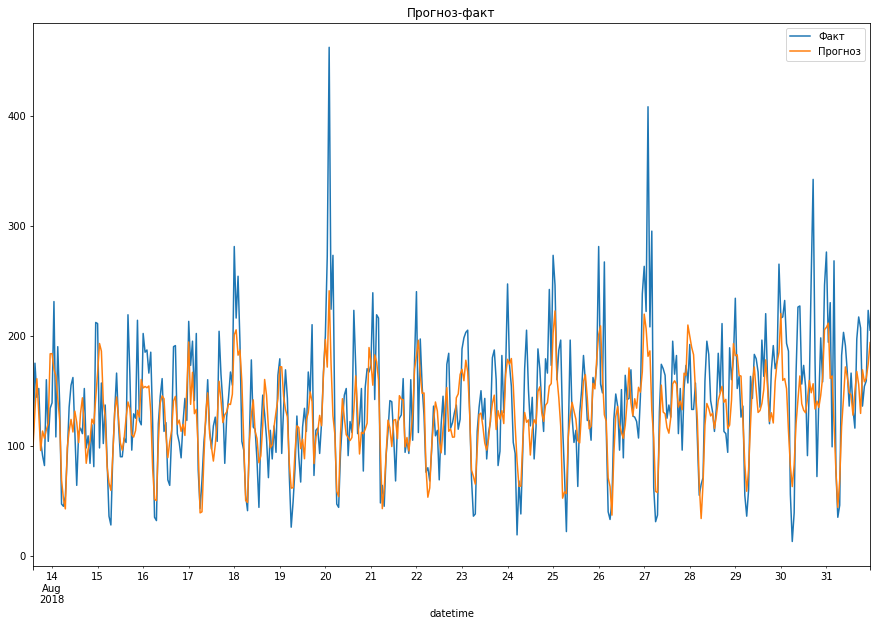

In [103]:
a = pd.DataFrame(data = {'Факт':target_test3.values,'Прогноз': predict_c}, index = target_test3.index)
a.plot(title = 'Прогноз-факт', figsize=(15, 10));

**Вывод:**

Мы подготовили признаки для обучения, затем обучили три модели: LghtGBM, Случайный лес и CatBoost. Подобрали сколько дополнительных признаков нам добавлять. Лучшей моделью на валидации вышла CatBoost. По условию необходимо получить ошибку менее 48 на тесте, чего мы и добились RMSE = 41.4. По графику "Прогноз-факт" можно увидеть, что данные прогноза достаточно близки по пикам к фактическим значениям.